In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")
def choose_top_rw(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.Rw, method='first')<=n)
def choose_top_vtotal(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.VTotal, method='first')<=n)
def choose_top(data,col="Qw", n=5, ascending=False):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending, method='first')<=n)

In [3]:
# protein_list = ["T0766", "1MBA", "T0784", "T0792", "T0803", "T0815", "T0833", "T0251"]
protein_list = ["T0766", "T0784", "T0803", "T0833", "T0251"]
name_list = ["Step" , "Chain" , "Shake" , "Chi" , "Rama", "Excluded", "DSSP", "P_AP", "Water" ,"Burial", "Helix", "AMH_Go", "Frag_Mem", "Vec_FM", "Membrane", "SSB" , "Electro.", "QGO" ,"VTotal"]
all_data_list = []

for protein in protein_list:
    awsem = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_awsem.log", names=name_list)
    rw = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_rw.txt", names=["i", "Rw"], sep="\s+")
    rmsd = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_rmsd.txt", names=["i2", "Rmsd"], sep="\s+")
    qw = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_qw.txt", names=["i3", "Qw"], sep="\s+")
    gdt = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_GDT.txt", names=["gdt"+str(i) for i in range(1,21)], sep="\s+")
    rw = rw.reset_index(drop=True)
    awsem = awsem.reset_index(drop=True)
    rmsd = rmsd.reset_index(drop=True)
    qw = qw.reset_index(drop=True)
    gdt["GDT"] = (gdt["gdt2"] + gdt["gdt4"] + gdt["gdt8"] + gdt["gdt16"])*25
    gdt = gdt.reset_index(drop=True)
    data = pd.concat([rw, qw, rmsd, gdt["GDT"], awsem], axis=1)
#     print(data)
    remove_columns = ['i', 'i2', 'i3', 'Step', "Shake", "Excluded", "AMH_Go", "Membrane", "Vec_FM", "SSB", "Electro."]
#     if protein == "T0251":
#         p = "T251"
#     elif protein == "1mba":
#         p = "1MBA"
#     else:
#         p = protein
    p = protein
    data = data.drop(remove_columns, axis=1).reset_index().assign(Name=p)
    all_data_list.append(data)
all_data = pd.concat(all_data_list).reset_index(drop=True)

In [15]:
all_data.columns

Index(['index', 'Rw', 'Qw', 'Rmsd', 'GDT', 'Chain', 'Chi', 'Rama', 'DSSP',
       'P_AP', 'Water', 'Burial', 'Helix', 'Frag_Mem', 'QGO', 'VTotal',
       'Name'],
      dtype='object')

In [4]:
print(all_data.shape)
all_data.dropna().shape

(10050, 17)


(10050, 17)

In [5]:
# all_data.to_csv("/Users/weilu/Research/data/test_data/test_data_mar27.csv")

In [6]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_4.csv")
raw_test_data_2 = raw_test_data.drop_duplicates(subset=['Qw', 'Rw', "VTotal"])
raw_test_data_2 = raw_test_data_2.assign(isGood=raw_test_data_2.groupby("Name")["GDT"].rank(ascending=False, method='first') < 51)
raw_test_data_old = raw_test_data_2.assign(VwithoutGo = raw_test_data.VTotal - raw_test_data.QGO)

In [34]:
a_back = a

In [35]:
raw_test_data_2 = a_back.drop_duplicates(subset=['Qw', 'Rw', "VTotal"])
raw_test_data_2 = raw_test_data_2.assign(isGood=raw_test_data_2.groupby("Name")["GDT"].rank(ascending=False, method='first') < 51)
raw_test_data_old = raw_test_data_2.assign(VwithoutGo = raw_test_data.VTotal - raw_test_data.QGO)

In [40]:
raw_test_data_old.shape

(6003, 20)

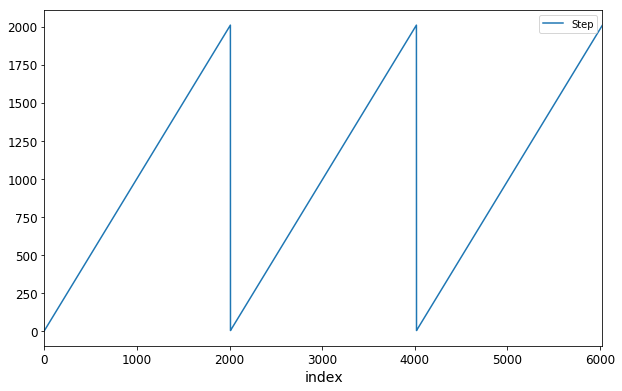

In [25]:
# a.reset_index().plot('index', "Step")
a = raw_test_data.query("Name not in @protein_list").query("Name != 'T251'").reset_index(drop=True)
protein_list = ["1MBA", "T0792", "T0815"]
all_rmsd_list = []

for protein in protein_list:
    rmsd = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_rmsd.txt", names=["i2", "Rmsd"], sep="\s+")
    rmsd = rmsd.reset_index(drop=True)
    print(rmsd.head())
    all_rmsd_list.append(rmsd)
all_rmsd = pd.concat(all_rmsd_list)
a["Rmsd"] = all_rmsd["Rmsd"].reset_index(drop=True)

In [41]:
raw_test_data.shape

(10000, 21)

In [ ]:
# def read_rmsd(protein):
#     rmsd = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_rmsd.txt", names=["i2", "Rmsd"], sep="\s+")
#     return rmsd["Rmsd"].reset_index(drop=True)
# a.groupby("Name").apply(lambda x: x["test"]=read_rmsd())

In [44]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_mar27.csv")
raw_test_data_2 = raw_test_data.drop_duplicates(subset=['Qw', 'Rw', "VTotal"])
raw_test_data_2 = raw_test_data_2.assign(isGood=raw_test_data_2.groupby("Name")["GDT"].rank(ascending=False, method='first') < 51)
raw_test_data = raw_test_data_2.assign(VwithoutGo = raw_test_data.VTotal - raw_test_data.QGO)
raw_test_data["Step"] = raw_test_data_2["index"]+1
# raw_test_data = raw_test_data_2
# a = raw_test_data_old.query("Name not in @protein_list").reset_index(drop=True)
raw_test_data = pd.concat([raw_test_data_old, raw_test_data.drop('Unnamed: 0', axis=1)])
raw_test_data = raw_test_data.query("Name != 'T251'").reset_index(drop=True)
raw_test_data = raw_test_data.query("Step != 1").reset_index(drop=True)

In [45]:
raw_test_data.shape

(16000, 21)

In [71]:
data_save = raw_test_data.drop("index", axis=1).drop("Good", axis=1)

In [72]:
data_save.to_csv("/Users/weilu/Research/data/test_data/complete_data_mar27.csv")

In [51]:
raw_test_data["Name"].unique()

array(['1MBA', 'T0792', 'T0815', 'T0766', 'T0784', 'T0803', 'T0833',
       'T0251'], dtype=object)

In [207]:
# raw_test_data[["Name", "Step", "Qw", "GDT"]].to_csv("/Users/weilu/Desktop/steps_qw_gdt.csv")

In [4]:
# all_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_mar03.csv")
# all_data = all_data.assign(VwithoutGo = all_data.VTotal - all_data.QGO)
# raw_test_data_2 = all_data
# raw_test_data_2 = all_data.assign(isGood=raw_test_data_2.groupby("Name")["Qw"].rank(ascending=False, method='first') < 6)
# raw_test_data = raw_test_data_2.assign(VwithoutGo = raw_test_data_2.VTotal - raw_test_data_2.QGO)

In [57]:
FEATURES = ['Rw',
#      'VTotal',
     'QGO',
     'VwithoutGo',
#      'Burial',
#      'Water',
#      'Rama',
#      'DSSP',
#      'P_AP',
#      'Helix',
#      'Frag_Mem'
               ]
n = 5
def my_transform(data, label, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    LABEL = label
    PolynomialDegree = degree

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    return full_pipeline.fit_transform(data)

def my_transform_predict(data, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    PolynomialDegree = degree

    num_attribs = FEATURES
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    return num_pipeline.fit_transform(data)

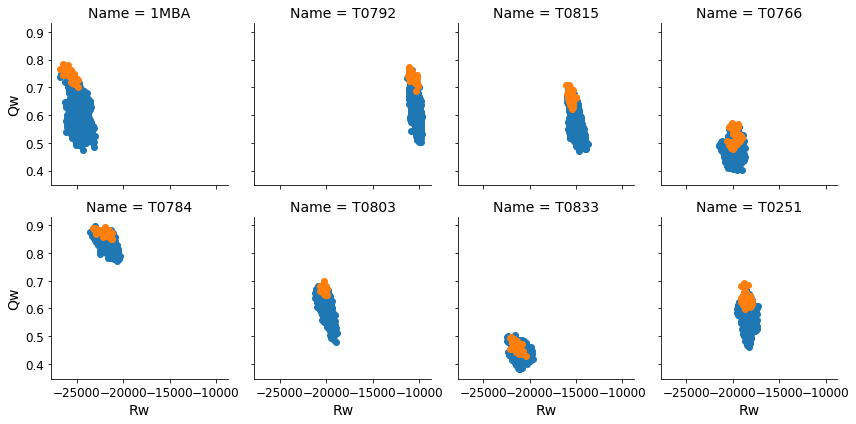

In [58]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "Rw", "Qw")

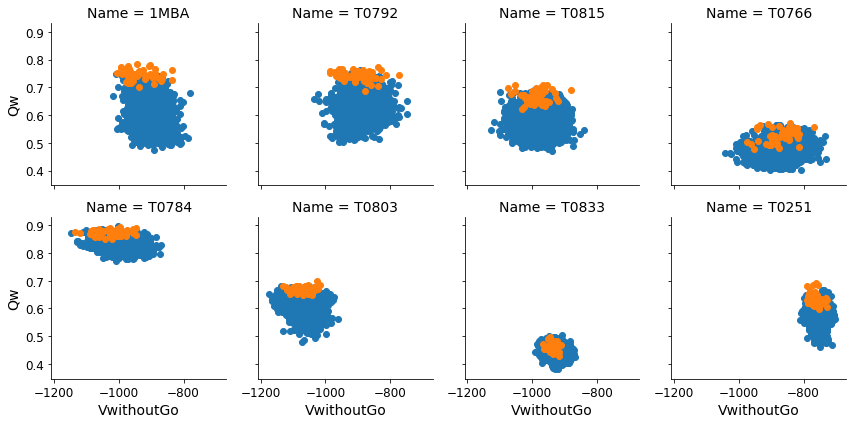

In [59]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "VwithoutGo", "Qw")

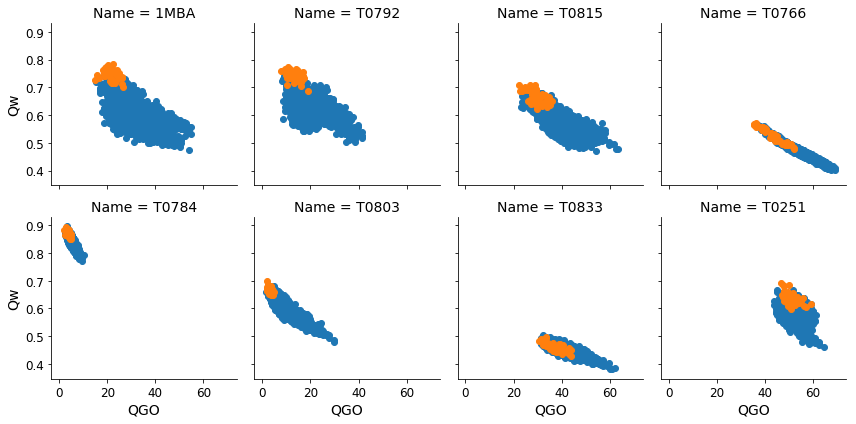

In [60]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "QGO", "Qw")

In [61]:
raw_data_T0784 = raw_test_data.groupby("Name").get_group("T0784")
# raw_data_T0792 = raw_test_data.groupby("Name").get_group("T0792")
# raw_data = pd.concat([raw_data_T0784, raw_data_T0792])
# raw_data = raw_data_T0792
# raw_data = raw_test_data.groupby("Name").get_group("1mba")
raw_data = raw_data_T0784


In [62]:
# FEATURES = ["Rw", "VTotal", "QGO"]
# FEATURES = ["Rw", "VTotal", "QGO", "Burial", "Frag_Mem", "Water"]
# FEATURES = list(raw_test_data.columns[2:-3])
def train_and_test(raw_data, label="Qw", degree=1, p=0.1):
    # my_full_pipeline = Pipeline([
    # #         ('removeFirstFrame', RemoveFirstFrame(frame)),
    #         ('featureSelection', full_pipeline)
    # ])

    from sklearn.model_selection import StratifiedShuffleSplit

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=142)
    for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
        strat_train_set = raw_data.iloc[train_index]
        strat_test_set = raw_data.iloc[test_index]
    # strat_test_set[LABEL].value_counts() / len(strat_test_set)
    X_train = my_transform(strat_train_set, label, degree)
    X_test = my_transform(strat_test_set, label, degree)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    test_y = X_test[:,-1]
    test_set = X_test[:,:-1]
    return (train_set, train_y, test_set, test_y)

In [63]:
label = "isGood"
degree = 1
p = 0.1
train_set, train_y, test_set, test_y = train_and_test(raw_data, label=label, degree=degree)
log_clf = LogisticRegression(random_state=140, penalty='l2')

# log_clf = LogisticRegression(random_state=14, class_weight={0:p, 1:(1-p)}, penalty='l1')
log_clf.fit(train_set, train_y)
y_pred = log_clf.predict(train_set)
# n = 100
prediction_list = []
for name, data in raw_test_data.groupby("Name"):
    print(name)
#     X = full_pipeline.fit_transform(data)
    X = my_transform(data, label, degree)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    one = data.assign(prediction=test)
    prediction_list.append(one)
#     prediction_list.append(pd.Series(test))
t = pd.concat(prediction_list)
# t = raw_test_data.assign(prediction=prediction.values)
best_by_prediction = t.groupby("Name").apply(choose_top, n=n, col="prediction").query("chosen==True")

1MBA
T0251
T0766
T0784
T0792
T0803
T0815
T0833


In [64]:
print(*(zip(FEATURES, log_clf.coef_[0])))

('Rw', -0.1923227527060043) ('QGO', -1.6223111058603821) ('VwithoutGo', -0.28966535406692889)


In [65]:
n = 5
chosen_by_rw = raw_test_data.groupby("Name").apply(choose_top_rw, n)
chosen_by_vtotal = raw_test_data.groupby("Name").apply(choose_top_vtotal, n)
chosen_by_qgo = raw_test_data.groupby("Name").apply(choose_top, n=n, col="QGO", ascending=True)
top_rw = chosen_by_rw.query("chosen==True")
top_vtotal = chosen_by_vtotal.query("chosen==True")
top_qgo = chosen_by_qgo.query("chosen==True")

In [66]:
top_qgo_old = top_qgo

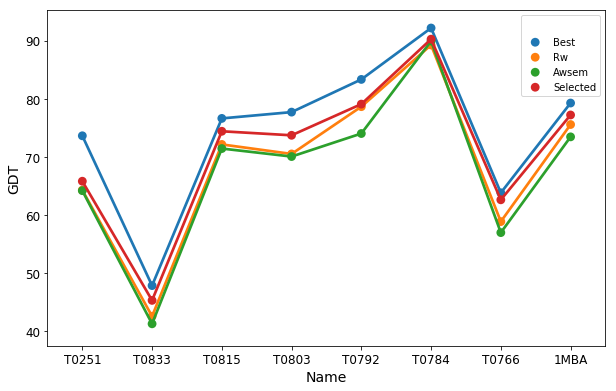

In [67]:
# T0784
label = "GDT"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
# plt.savefig("/Users/weilu/Desktop/test.png", dpi=300)
# plt.ylim([0.4,1])

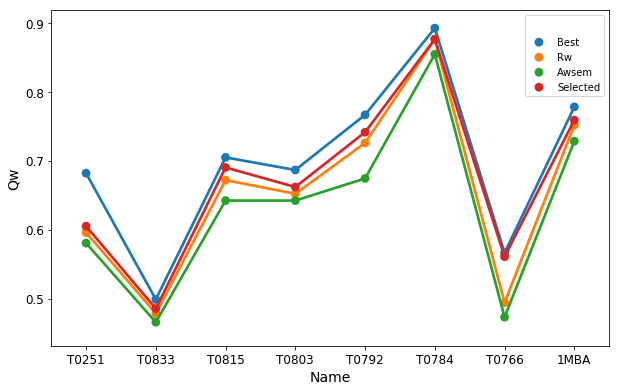

In [68]:
# T0784
label = "Qw"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
# plt.savefig("/Users/weilu/Desktop/test.png", dpi=300)
# plt.ylim([0.4,1])

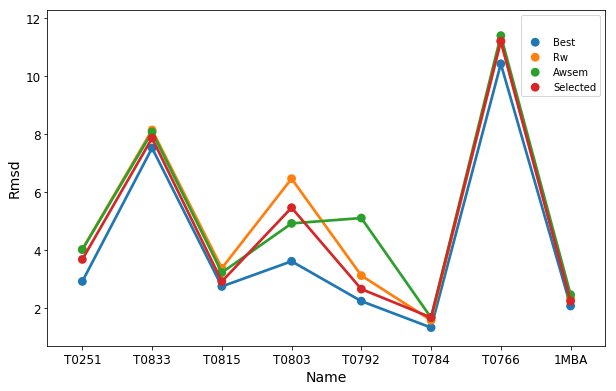

In [70]:
# T0784
label = "Rmsd"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label, ascending=True).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
# plt.savefig("/Users/weilu/Desktop/test.png", dpi=300)
# plt.ylim([0.4,1])

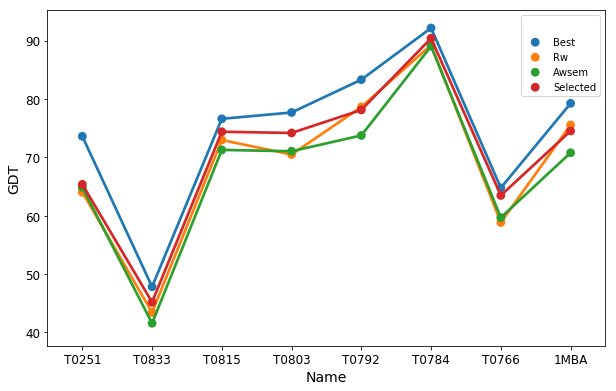

In [178]:
# T0784
label = "GDT"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/test.png", dpi=300)
# plt.ylim([0.4,1])

In [195]:
a = best_by_prediction.reset_index(drop=True)[["Name", "Qw", "GDT", "prediction", "Step"]].groupby("Name").apply(lambda x: x.sort_values("prediction", ascending=False))

In [196]:
import itertools

In [198]:
a.reset_index(drop=True).to_csv("/Users/weilu/Desktop/selected.csv")

In [197]:
a.reset_index(drop=True).set_index("Name")


,Qw,GDT,prediction,Step
Name,,,,
1MBA,0.720428,74.8275,0.306414,110
1MBA,0.769650,78.4275,0.295674,186
1MBA,0.764916,76.2000,0.259163,189
1MBA,0.765128,77.9100,0.258174,200
1MBA,0.774211,78.5975,0.251528,154
T0251,0.613264,66.4375,0.490454,606
T0251,0.598274,65.0475,0.392429,1086
T0251,0.589351,62.5000,0.383658,1214
T0251,0.598703,66.6700,0.368319,1643


In [154]:
raw_test_data.groupby("Name").apply(choose_top, n=1, col="Step", ascending=True).query("chosen==True")[["Name", "GDT", "Qw", "Step"]]

,,Name,GDT,Qw,Step
Name,,,,,
1MBA,0,1MBA,65.2400,0.638744,1
T0251,14007,T0251,66.2050,0.655897,0
T0766,6003,T0766,67.8250,0.617307,0
T0784,8004,T0784,86.0000,0.838527,0
T0792,2001,T0792,74.0625,0.675483,1
T0803,10005,T0803,74.0675,0.671503,0
T0815,4002,T0815,74.7625,0.672388,1
T0833,12006,T0833,43.2875,0.487200,0


In [80]:
best_by_prediction.reset_index(drop=True)[["Name", "GDT", "Qw"]].groupby("Name").mean()

,GDT,Qw
Name,,
1MBA,74.5210,0.731773
T0251,65.3720,0.611098
T0766,63.4720,0.574620
T0784,90.4000,0.880746
T0792,78.1250,0.726105
T0803,74.1795,0.667197
T0815,74.3870,0.685202
T0833,45.1875,0.489990


In [69]:
raw_test_data.groupby("Name").apply(choose_top, n=1, col=label).query("chosen==True")[["GDT"]]

,,GDT
Name,,
1MBA,181,80.1375
T0251,15448,74.7675
T0766,6003,67.8250
T0784,9592,92.6000
T0792,3586,84.3750
T0803,10113,78.1700
T0815,4434,77.3550
T0833,13188,48.3800


In [70]:
raw_test_data.groupby("Name").apply(choose_top, n=1, col="Qw").query("chosen==True")[["Qw"]]

,,Qw
Name,,
1MBA,198,0.782962
T0251,15448,0.691465
T0766,6003,0.617307
T0784,9385,0.896806
T0792,2187,0.772617
T0803,10113,0.700119
T0815,4434,0.710136
T0833,12215,0.502726


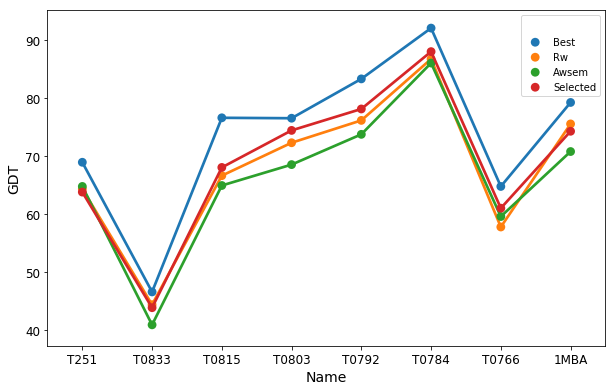

In [22]:
# T0784
label = "GDT"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
# plt.savefig("/Users/weilu/Desktop/test.png", dpi=300)
# plt.ylim([0.4,1])

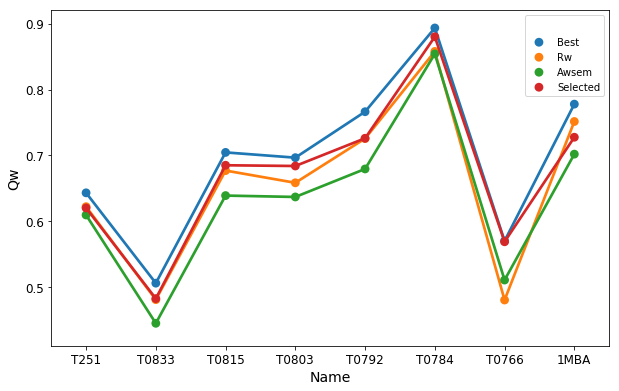

In [24]:
# T0784
label = "Qw"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/figure6_qw.png", dpi=300)
# plt.ylim([0.4,1])

In [16]:
initial = raw_test_data.groupby("Name").apply(choose_top, n=1, col='Step', ascending=True).query("chosen==True")
f2 = initial.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Initial"})

In [18]:
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})

NameError: name 'best' is not defined

In [19]:
f2.melt(id_vars="Name", value_name=label, var_name=" ")

,Name,,isGood
0,1MBA,Initial,False
1,T0766,Initial,True
2,T0784,Initial,False
3,T0792,Initial,False
4,T0803,Initial,True
5,T0815,Initial,True
6,T0833,Initial,False
7,T251,Initial,False


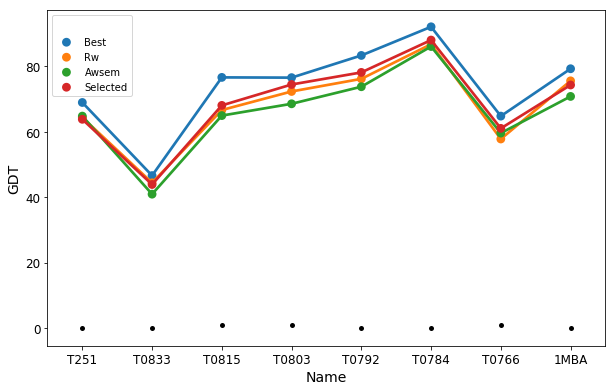

In [20]:
# T0784
label = "GDT"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
# plt.clf()
t = f2.melt(id_vars="Name", value_name=label, var_name=" ")
sns.stripplot("Name", label, data=t, order=order, color="black")
# plt.savefig("/Users/weilu/Desktop/test.png", dpi=300)
# plt.ylim([0.4,1])

In [55]:
best_old = best

In [146]:
# best_by_prediction.to_csv("/Users/weilu/Research/data/structure_selector_mar03/old_best_by_prediction.csv")

In [162]:
protein_list = ["T0766", "1mba", "T0784", "T0792", "T0803", "T0815", "T0833", "T0251"]
name_list = ["Step" , "Chain" , "Shake" , "Chi" , "Rama", "Excluded", "DSSP", "P_AP", "Water" ,"Burial", "Helix", "AMH_Go", "Frag_Mem", "Vec_FM", "Membrane", "SSB" , "Electro.", "QGO" ,"VTotal"]
all_data_list = []
for protein in protein_list:
    awsem = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar03/{protein}_awsem.log", names=name_list)
    rw = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar03/{protein}_rw.txt", names=["i", "Rw"], sep="\s+")
    rmsd = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar03/{protein}_rmsd.txt", names=["i2", "Rmsd"], sep="\s+")
    qw = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar03/{protein}_qw.txt", names=["i3", "Qw"], sep="\s+")
    rw = rw[:2000].reset_index(drop=True)
    awsem = awsem[:2000].reset_index(drop=True)
    rmsd = rmsd[:2000].reset_index(drop=True)
    qw = qw[:2000].reset_index(drop=True)
    data = pd.concat([rw, awsem, rmsd, qw], axis=1)
    remove_columns = ['i', 'i2', 'i3', 'Step', "Shake", "Excluded", "AMH_Go", "Membrane", "Vec_FM", "SSB", "Electro."]
    if protein == "T0251":
        p = "T251"
    elif protein == "1mba":
        p = "1MBA"
    else:
        p = protein
    data = data.drop(remove_columns, axis=1).reset_index().assign(Name=p)
    all_data_list.append(data)
all_data = pd.concat(all_data_list).reset_index(drop=True)

In [16]:
a = raw_test_data.query("Name=='1MBA'").assign(T='old')

In [17]:
b = all_data.query("Name=='1MBA'").assign(T='new')

In [18]:
c = pd.concat([a,b])

In [ ]:
b

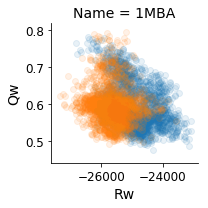

In [19]:
g = sns.FacetGrid(c, col="Name", hue="T", col_wrap=1)
g = g.map(plt.scatter, "Rw", "Qw", alpha=0.1)

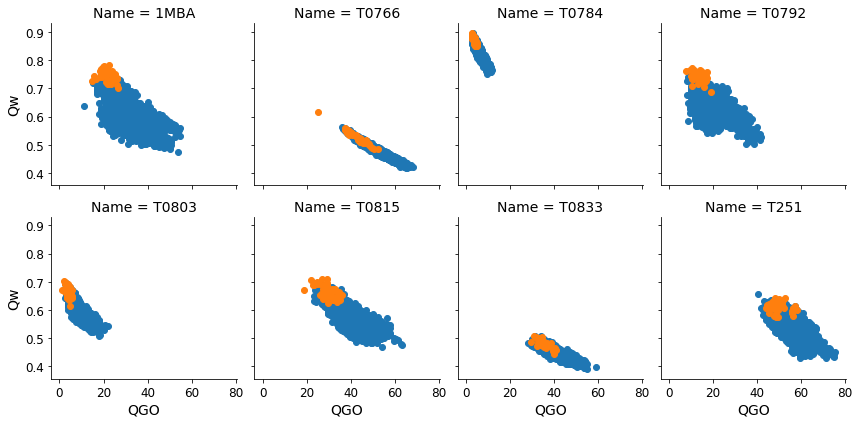

In [23]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "QGO", "Qw")

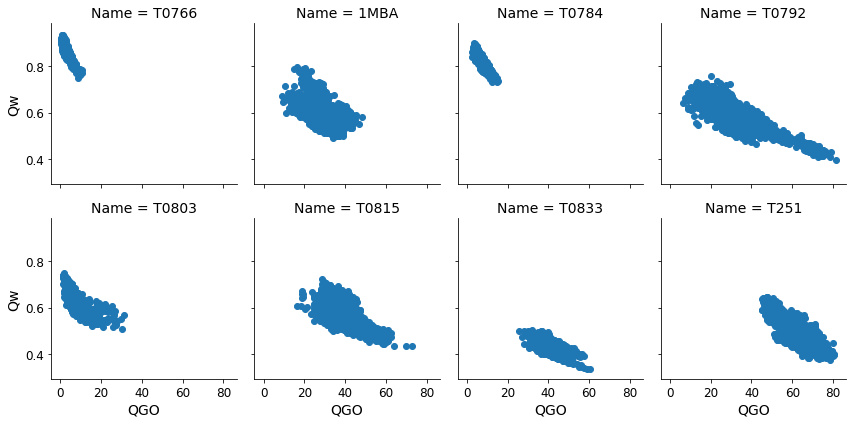

In [22]:
g = sns.FacetGrid(all_data, col="Name", col_wrap=4)
g = g.map(plt.scatter, "QGO", "Qw")

In [163]:
# all_data.to_csv("/Users/weilu/Research/data/test_data/test_data_mar05.csv")

In [79]:
all_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_mar05.csv")
all_data = all_data.assign(VwithoutGo = all_data.VTotal - all_data.QGO)

In [80]:
prediction_list = []
for name, data in all_data.groupby("Name"):
    print(name)
#     X = full_pipeline.fit_transform(data)
    X = my_transform_predict(data, degree=1)
    eval_set = X
    test= log_clf.predict_proba(eval_set)[:,1]
    one = data.assign(prediction=test)
    prediction_list.append(one)
#     prediction_list.append(pd.Series(test))
t = pd.concat(prediction_list)
# t = all_data.assign(prediction=prediction.values)
best_by_prediction_new = t.groupby("Name").apply(choose_top, n=n, col="prediction").query("chosen==True").drop('Unnamed: 0',axis=1)

1MBA
T0766
T0784
T0792
T0803
T0815
T0833
T251


In [34]:
best_by_prediction_new

index            Rw       Chain        Chi        Rama  \
Name                                                                  
1MBA  2000       0 -26473.201583  167.564260  30.265355 -649.046369   
      2402     402 -25524.115997  162.588117  29.871546 -637.486851   
      3005    1005 -25586.216265  166.137087  34.751798 -624.929558   
      3206    1206 -26641.596220  143.172577  33.238930 -643.767739   
      3608    1608 -25708.255549  150.437122  38.305480 -617.734785   
T0766 311      311 -17704.811371  123.990918  22.735052 -380.398660   
      690      690 -17639.457992  148.283830  30.621936 -378.756833   
      694      694 -17452.458817  147.666186  21.177155 -370.783486   
      762      762 -17563.616919  149.511441  28.270570 -389.741613   
      1597    1597 -17647.474507  140.051354  25.654790 -370.026178   
T0784 4425     425 -18531.462212  185.730963  34.946650 -450.223942   
      4426     426 -18340.014479  179.491019  30.393790 -438.113931   
      4436     436 -18549.235385  140.277430  24.474562 -430.603214   
      4437     437 -18300.385795  186.116508  38.522451 -419.742656   
      4464     464 -18215.560827  173.797530  34.959398 -433.576657   
T0792 6000       0 -10722.090867    0.000000   0.000000 -322.603244   
      6201     201 -10802.793172    0.000000   0.000000 -311.411630   
      7005    1005 -10933.898349    0.000000   0.000000 -318.108106   
      7608    1608 -10483.371159    0.000000   0.000000 -310.550875   
      7809    1809 -11238.544141    0.000000   0.000000 -310.800775   
T0803 8151     151 -20703.421673  148.579686  33.980616 -427.281804   
      8164     164 -20766.225860  165.328464  42.379268 -429.637537   
      8180     180 -20933.535882  193.697896  34.969874 -416.429394   
      8190     190 -20844.962110  179.110734  31.733673 -424.041076   
      8193     193 -20906.030632  173.850768  28.992856 -423.359886   
T0815 10000      0 -15635.174335    0.000000   0.000000 -494.048924   
      10603    603 -15826.858040    0.000000   0.000000 -478.167582   
      11005   1005 -16052.966800    0.000000   0.000000 -496.182245   
      11206   1206 -15878.678416    0.000000   0.000000 -490.126164   
      11608   1608 -16093.073170    0.000000   0.000000 -493.028360   
T0833 12000      0 -14347.027331  125.898222  23.989866 -439.957297   
      12402    402 -14743.328182  158.058162  24.461995 -444.935460   
      12804    804 -13823.640680  159.231026  23.597154 -450.461446   
      13005   1005 -15024.095932  149.112160  24.551428 -446.849817   
      13809   1809 -13749.486003  136.957995  25.944084 -450.714461   
T251  15050   1050 -18772.633497    0.000000   0.000000 -415.567625   
      15063   1063 -18801.931114    0.000000   0.000000 -413.303745   
      15078   1078 -18822.844179    0.000000   0.000000 -424.379341   
      15113   1113 -18815.917771    0.000000   0.000000 -403.550604   
      15147   1147 -18800.856827    0.000000   0.000000 -393.652214   

                  DSSP       P_AP      Water      Burial      Helix  \
Name                                                                  
1MBA  2000   -0.000234  -7.145992 -62.636467 -124.256792 -58.545028   
      2402   -0.000000  -6.117750 -59.092704 -122.056701 -53.978581   
      3005   -0.000000  -3.735631 -57.344730 -124.972776 -55.668879   
      3206   -0.000000  -6.162572 -66.052242 -122.966350 -60.798873   
      3608   -0.000000  -5.084803 -58.348555 -124.568879 -57.987746   
T0766 311   -55.805090 -26.587830 -53.205623  -94.569191 -11.074971   
      690   -53.457257 -27.462251 -48.533265  -95.326469 -11.294877   
      694   -52.938989 -28.206054 -52.597858  -91.350741 -10.367621   
      762   -52.871474 -28.166277 -51.905238  -93.320169 -11.444771   
      1597  -53.598729 -27.379476 -52.964184  -93.993429 -10.296802   
T0784 4425  -64.001365 -43.157142 -53.390888 -109.582820  -0.010833   
      4426  -66.980525 -44.054194 -50.487615 -108.206247  -0.005735   
      4436  -68.431445 -46.133949 -5

In [37]:
top_qgo

Unnamed: 0  index            Rw       Chain        Chi  \
Name                                                                  
1MBA  2000         2000      0 -26473.201583  167.564260  30.265355   
      2010         2010     10 -25268.085249  175.498256  46.713784   
      3005         3005   1005 -25586.216265  166.137087  34.751798   
      3206         3206   1206 -26641.596220  143.172577  33.238930   
      3608         3608   1608 -25708.255549  150.437122  38.305480   
T0766 311           311    311 -17704.811371  123.990918  22.735052   
      690           690    690 -17639.457992  148.283830  30.621936   
      694           694    694 -17452.458817  147.666186  21.177155   
      698           698    698 -17490.516533  138.794636  26.518857   
      771           771    771 -17537.167695  132.780644  24.938543   
T0784 4418         4418    418 -18188.998927  181.910453  23.631139   
      4426         4426    426 -18340.014479  179.491019  30.393790   
      4437         4437    437 -18300.385795  186.116508  38.522451   
      4464         4464    464 -18215.560827  173.797530  34.959398   
      5206         5206   1206 -17229.795749  156.635971  26.468856   
T0792 6000         6000      0 -10722.090867    0.000000   0.000000   
      6603         6603    603 -10494.787655    0.000000   0.000000   
      6807         6807    807 -10526.486998    0.000000   0.000000   
      7005         7005   1005 -10933.898349    0.000000   0.000000   
      7608         7608   1608 -10483.371159    0.000000   0.000000   
T0803 8011         8011     11 -20150.122364  196.969052  39.688194   
      8150         8150    150 -20755.376084  178.736440  40.743517   
      8151         8151    151 -20703.421673  148.579686  33.980616   
      8164         8164    164 -20766.225860  165.328464  42.379268   
      8180         8180    180 -20933.535882  193.697896  34.969874   
T0815 10000       10000      0 -15635.174335    0.000000   0.000000   
      10201       10201    201 -15628.174659    0.000000   0.000000   
      10603       10603    603 -15826.858040    0.000000   0.000000   
      11005       11005   1005 -16052.966800    0.000000   0.000000   
      11608       11608   1608 -16093.073170    0.000000   0.000000   
T0833 12000       12000      0 -14347.027331  125.898222  23.989866   
      12804       12804    804 -13823.640680  159.231026  23.597154   
      13005       13005   1005 -15024.095932  149.112160  24.551428   
      13690       13690   1690 -14635.795571  182.370145  27.715998   
      13809       13809   1809 -13749.486003  136.957995  25.944084   
T251  15050       15050   1050 -18772.633497    0.000000   0.000000   
      15057       15057   1057 -18550.424560    0.000000   0.000000   
      15063       15063   1063 -18801.931114    0.000000   0.000000   
      15113       15113   1113 -18815.917771    0.000000   0.000000   
      15147       15147   1147 -18800.856827    0.000000   0.000000   

                   Rama       DSSP       P_AP      Water      Burial  \
Name                                                                   
1MBA  2000  -649.046369  -0.000234  -7.145992 -62.636467 -124.256792   
      2010  -603.109631  -0.000002  -5.496606 -52.694837 -125.160438   
      3005  -624.929558  -0.000000  -3.735631 -57.344730 -124.972776   
      3206  -643.767739  -0.000000  -6.162572 -66.052242 -122.966350   
      3608  -617.734785  -0.000000  -5.084803 -58.348555 -124.568879   
T0766 311   -380.398660 -55.805090 -26.587830 -53.205623  -94.569191   
      690   -378.756833 -53.457257 -27.462251 -48.533265  -95.326469   
      694   -370.783486 -52.938989 -28.206054 -52.597858  -91.350741   
      698   -374.228818 -56.553755 -27.631732 -48.891709  -92.588012   
      771   -376.958192 -53.481557 -27.646844 -51.700067  -93.309125   
T0784 4418  -443.361765 -66.420464 -45.611108 -48.179328 -108.106543   
      4426  -438.113931 -66.980525 -44.054194 -50.487615 -108.206247   
      4437  -419.74265

In [63]:
best_old.query("Name == '1MBA'")

Step        Qw            Rw      VTotal        QGO      Burial  \
Name                                                                        
1MBA 87     88  0.752795 -25692.055976 -864.423582  25.042131 -124.594161   
     177   178  0.750668 -25813.483182 -946.915090  21.671959 -125.739936   
     181   182  0.779434 -25916.345599 -882.478750  20.135328 -123.754336   
     191   192  0.776781 -26311.813555 -949.413109  20.736743 -125.154787   
     198   199  0.782962 -26440.114210 -919.799652  22.403743 -126.716933   

              Water        Rama       Chain        Chi      DSSP      P_AP  \
Name                                                                         
1MBA 87  -52.906979 -592.605726  188.990816  34.977292 -0.000000 -6.610606   
     177 -56.475336 -632.644194  182.904382  41.451079 -0.000016 -6.830135   
     181 -51.047253 -607.056528  202.963107  38.336534 -0.000000 -6.093471   
     191 -53.136842 -627.009584  171.621313  35.537802 -0.000000 -6.592100   
     198 -55.753767 -618.107374  181.551899  44.976356 -0.000000 -7.731975   

              Helix    Frag_Mem      GDT  Name  Good  isGood  VwithoutGo  \
Name                                                                       
1MBA 87  -48.899861 -287.816488  78.7675  1MBA     1    True -889.465713   
     177 -49.949306 -321.303585  78.9400  1MBA     1    True -968.587049   
     181 -55.170120 -300.792013  80.1375  1MBA     1    True -902.614078   
     191 -51.940474 -313.475180  78.7700  1MBA     1    True -970.149852   
     198 -53.638502 -306.783099  79.6250  1MBA     1    True -942.203395   

          chosen  
Name              
1MBA 87     True  
     177    True  
     181    True  
     191    True  
     198    True

In [62]:
best.query("Name == '1MBA'")

Unnamed: 0  index            Rw       Chain        Chi        Rama  \
Name                                                                            
1MBA 3823        3823   1823 -26232.335774  189.596152  35.460661 -618.748898   
     3841        3841   1841 -25826.216986  190.824793  42.227748 -609.542339   
     3842        3842   1842 -26118.417369  192.759801  43.769817 -631.906384   
     3848        3848   1848 -25219.863446  181.894497  42.536336 -605.696763   
     3852        3852   1852 -25742.081124  188.596295  38.201283 -609.710042   

               DSSP      P_AP      Water      Burial      Helix    Frag_Mem  \
Name                                                                          
1MBA 3823 -0.000503 -5.815691 -63.689887 -124.425383 -57.144515 -312.985211   
     3841 -0.001961 -5.439514 -59.998549 -123.361484 -56.063272 -312.955824   
     3842 -0.000833 -4.979912 -55.774995 -124.321893 -49.977464 -324.209426   
     3848 -0.000000 -4.787451 -55.609406 -124.642595 -51.204588 -299.959334   
     3852 -0.000004 -6.442622 -57.853857 -124.720334 -53.236209 -310.864647   

                 QGO      VTotal     Rmsd        Qw  Name  VwithoutGo  chosen  
Name                                                                           
1MBA 3823  15.114680 -942.638594  1.85442  0.789202  1MBA -957.753274    True  
     3841  20.436977 -913.873423  1.88108  0.792109  1MBA -934.310400    True  
     3842  17.400915 -937.240373  1.88540  0.784810  1MBA -954.641288    True  
     3848  16.311303 -901.158001  1.89601  0.795368  1MBA -917.469304    True  
     3852  19.522207 -916.507930  1.92628  0.785317  1MBA -936.030137    True

In [82]:
top_qgo_old.query("Name == '1MBA'")

Step        Qw            Rw       VTotal        QGO      Burial  \
Name                                                                         
1MBA 0       1  0.638744 -25808.704023 -1020.093843  11.154204 -122.945417   
     107   108  0.725040 -24913.262398  -819.639401  14.983033 -125.982809   
     108   109  0.744714 -25298.265363  -885.076730  15.608216 -124.227303   
     109   110  0.720428 -24868.848781  -947.119845  15.175482 -124.242780   
     110   111  0.732315 -25033.617103  -861.470382  16.484788 -125.418972   

              Water        Rama       Chain        Chi      DSSP      P_AP  \
Name                                                                         
1MBA 0   -65.130893 -615.658035  166.869218  38.730319 -0.000000 -5.988391   
     107 -56.240570 -589.917850  222.916933  55.422419 -0.000000 -5.200737   
     108 -57.805159 -606.186362  202.728519  36.668636 -0.000000 -7.191742   
     109 -51.339404 -616.821418  158.855236  30.323929 -0.000002 -4.705667   
     110 -55.773822 -580.602912  184.613350  45.787692 -0.000000 -4.225123   

              Helix    Frag_Mem      GDT  Name  Good  isGood   VwithoutGo  \
Name                                                                        
1MBA 0   -58.381041 -368.743807  65.2400  1MBA     0   False -1031.248047   
     107 -47.471042 -288.148779  76.1975  1MBA     0    True  -834.622434   
     108 -47.646001 -297.025534  76.7125  1MBA     1    True  -900.684946   
     109 -51.621281 -302.743939  74.8275  1MBA     0   False  -962.295327   
     110 -46.424569 -295.910815  75.6875  1MBA     0    True  -877.955170   

          chosen  
Name              
1MBA 0      True  
     107    True  
     108    True  
     109    True  
     110    True

In [83]:
top_qgo.query("Name == '1MBA'")

Unnamed: 0  index            Rw       Chain        Chi        Rama  \
Name                                                                            
1MBA 2000        2000      0 -26473.201583  167.564260  30.265355 -649.046369   
     2010        2010     10 -25268.085249  175.498256  46.713784 -603.109631   
     3005        3005   1005 -25586.216265  166.137087  34.751798 -624.929558   
     3206        3206   1206 -26641.596220  143.172577  33.238930 -643.767739   
     3608        3608   1608 -25708.255549  150.437122  38.305480 -617.734785   

               DSSP      P_AP      Water      Burial      Helix    Frag_Mem  \
Name                                                                          
1MBA 2000 -0.000234 -7.145992 -62.636467 -124.256792 -58.545028 -369.651386   
     2010 -0.000002 -5.496606 -52.694837 -125.160438 -46.670344 -297.265618   
     3005 -0.000000 -3.735631 -57.344730 -124.972776 -55.668879 -351.836631   
     3206 -0.000000 -6.162572 -66.052242 -122.966350 -60.798873 -387.787094   
     3608 -0.000000 -5.084803 -58.348555 -124.568879 -57.987746 -385.741798   

                 QGO       VTotal     Rmsd        Qw  Name   VwithoutGo  \
Name                                                                      
1MBA 2000   9.083653 -1064.368999  2.35034  0.671072  1MBA -1073.452652   
     2010  10.418770  -897.766665  2.38582  0.715542  1MBA  -908.185435   
     3005  11.091300 -1006.508022  2.46273  0.661575  1MBA -1017.599322   
     3206   9.568414 -1101.554949  2.62836  0.646248  1MBA -1111.123363   
     3608   9.961194 -1050.762769  2.75558  0.647979  1MBA -1060.723963   

           chosen  
Name               
1MBA 2000    True  
     2010    True  
     3005    True  
     3206    True  
     3608    True

(0.4, 1)

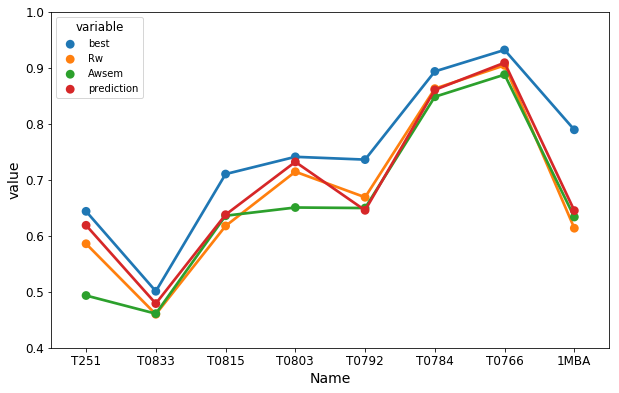

In [81]:
raw_test_data = all_data
chosen_by_rw = raw_test_data.groupby("Name").apply(choose_top_rw, n)
chosen_by_vtotal = raw_test_data.groupby("Name").apply(choose_top_vtotal, n)
chosen_by_qgo = raw_test_data.groupby("Name").apply(choose_top, n=n, col="QGO", ascending=True)
top_rw = chosen_by_rw.query("chosen==True")
top_vtotal = chosen_by_vtotal.query("chosen==True")
top_qgo = chosen_by_qgo.query("chosen==True")
# T0784
label = "Qw"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction_new.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
# sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)
order = ["T251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0, order=order)
plt.ylim([0.4,1])

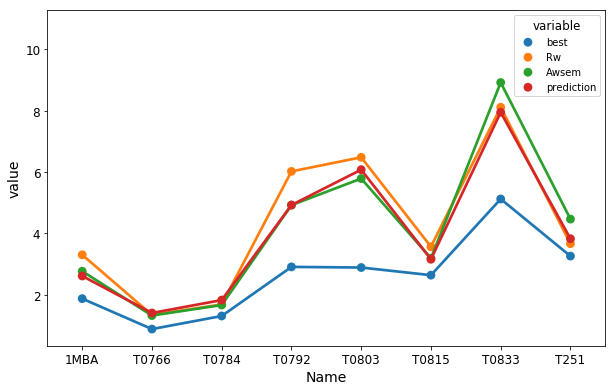

In [27]:
raw_test_data = all_data
chosen_by_rw = raw_test_data.groupby("Name").apply(choose_top_rw, n)
chosen_by_vtotal = raw_test_data.groupby("Name").apply(choose_top_vtotal, n)
chosen_by_qgo = raw_test_data.groupby("Name").apply(choose_top, n=n, col="QGO", ascending=True)
top_rw = chosen_by_rw.query("chosen==True")
top_vtotal = chosen_by_vtotal.query("chosen==True")
top_qgo = chosen_by_qgo.query("chosen==True")
# T0784
label = "Rmsd"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label, ascending=True).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction_new.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [30]:
t.groupby("Name").apply(choose_top, n=n, col=label, ascending=True).query("chosen==True")

Unnamed: 0  index            Rw       Chain        Chi  \
Name                                                                  
1MBA  3823         3823   1823 -26232.335774  189.596152  35.460661   
      3841         3841   1841 -25826.216986  190.824793  42.227748   
      3842         3842   1842 -26118.417369  192.759801  43.769817   
      3844         3844   1844 -25939.834499  168.108895  44.270209   
      3846         3846   1846 -25260.390589  174.441583  35.037820   
T0766 11             11     11 -17610.786968  140.064496  31.921209   
      14             14     14 -17488.004578  134.156068  26.159178   
      145           145    145 -17799.913072  133.944871  29.038961   
      159           159    159 -17739.398137  157.518499  31.513654   
      170           170    170 -17518.655339  142.194580  28.061999   
T0784 4656         4656    656 -18182.869756  159.902743  28.274408   
      4707         4707    707 -17889.838844  199.084705  30.293010   
      4709         4709    709 -18215.133112  167.827729  34.423890   
      4760         4760    760 -18205.063463  180.301390  23.506033   
      5800         5800   1800 -18496.515093  183.992209  38.487248   
T0792 7273         7273   1273 -10946.237972    0.000000   0.000000   
      7275         7275   1275 -11039.342805    0.000000   0.000000   
      7294         7294   1294 -10655.995027    0.000000   0.000000   
      7402         7402   1402 -10793.834310    0.000000   0.000000   
      7404         7404   1404 -10731.612651    0.000000   0.000000   
T0803 9488         9488   1488 -20248.138423  181.261899  32.738907   
      9491         9491   1491 -20173.824994  201.334146  39.663152   
      9505         9505   1505 -20313.107327  176.066419  34.247895   
      9506         9506   1506 -20193.141783  178.508596  38.742196   
      9602         9602   1602 -20073.057582  188.855923  36.821268   
T0815 10380       10380    380 -15523.793293    0.000000   0.000000   
      10381       10381    381 -15428.884504    0.000000   0.000000   
      10382       10382    382 -15635.030044    0.000000   0.000000   
      10383       10383    383 -15386.517419    0.000000   0.000000   
      10384       10384    384 -15753.780147    0.000000   0.000000   
T0833 12020       12020     20 -13979.647839  206.370839  36.745797   
      12029       12029     29 -14331.635646  170.128126  24.135122   
      12030       12030     30 -14313.763858  157.004610  29.241317   
      12031       12031     31 -14143.341482  169.052100  32.689558   
      12032       12032     32 -13993.598308  179.180204  38.456738   
T251  15154       15154   1154 -18638.364805    0.000000   0.000000   
      15157       15157   1157 -18591.106567    0.000000   0.000000   
      15188       15188   1188 -18498.250299    0.000000   0.000000   
      15194       15194   1194 -18678.389619    0.000000   0.000000   
      15198       15198   1198 -18602.923360    0.000000   0.000000   

                   Rama       DSSP       P_AP      Water      Burial  \
Name                                                                   
1MBA  3823  -618.748898  -0.000503  -5.815691 -63.689887 -124.425383   
      3841  -609.542339  -0.001961  -5.439514 -59.998549 -123.361484   
      3842  -631.906384  -0.000833  -4.979912 -55.774995 -124.321893   
      3844  -601.552514  -0.001759  -4.541572 -57.346743 -122.843221   
      3846  -625.700863  -0.000000  -5.423509 -54.621542 -124.184832   
T0766 11    -388.034988 -52.074436 -26.167400 -50.865315  -94.782419   
      14    -403.966887 -52.329765 -27.346378 -49.714602  -93.741849   
      145   -380.237626 -53.011393 -28.277909 -52.516315  -94.192181   
      159   -379.868497 -52.717965 -27.255639 -53.654383  -94.340106   
      170   -377.495609 -49.859304 -27.342028 -51.352910  -93.176664   
T0784 4656  -435.774413 -61.456801 -42.808967 -53.577431 -108.479900   
      4707  -431.198824 -65.887055 -40.098639 -54.846292 -108.428142   
      4709  -446.21836

In [28]:
best_by_prediction

index            Rw       Chain        Chi        Rama  \
Name                                                                  
1MBA  2000       0 -26473.201583  167.564260  30.265355 -649.046369   
      2402     402 -25524.115997  162.588117  29.871546 -637.486851   
      3005    1005 -25586.216265  166.137087  34.751798 -624.929558   
      3206    1206 -26641.596220  143.172577  33.238930 -643.767739   
      3608    1608 -25708.255549  150.437122  38.305480 -617.734785   
T0766 311      311 -17704.811371  123.990918  22.735052 -380.398660   
      690      690 -17639.457992  148.283830  30.621936 -378.756833   
      694      694 -17452.458817  147.666186  21.177155 -370.783486   
      762      762 -17563.616919  149.511441  28.270570 -389.741613   
      1597    1597 -17647.474507  140.051354  25.654790 -370.026178   
T0784 4425     425 -18531.462212  185.730963  34.946650 -450.223942   
      4426     426 -18340.014479  179.491019  30.393790 -438.113931   
      4436     436 -18549.235385  140.277430  24.474562 -430.603214   
      4437     437 -18300.385795  186.116508  38.522451 -419.742656   
      4464     464 -18215.560827  173.797530  34.959398 -433.576657   
T0792 6000       0 -10722.090867    0.000000   0.000000 -322.603244   
      6201     201 -10802.793172    0.000000   0.000000 -311.411630   
      7005    1005 -10933.898349    0.000000   0.000000 -318.108106   
      7608    1608 -10483.371159    0.000000   0.000000 -310.550875   
      7809    1809 -11238.544141    0.000000   0.000000 -310.800775   
T0803 8151     151 -20703.421673  148.579686  33.980616 -427.281804   
      8164     164 -20766.225860  165.328464  42.379268 -429.637537   
      8180     180 -20933.535882  193.697896  34.969874 -416.429394   
      8190     190 -20844.962110  179.110734  31.733673 -424.041076   
      8193     193 -20906.030632  173.850768  28.992856 -423.359886   
T0815 10000      0 -15635.174335    0.000000   0.000000 -494.048924   
      10603    603 -15826.858040    0.000000   0.000000 -478.167582   
      11005   1005 -16052.966800    0.000000   0.000000 -496.182245   
      11206   1206 -15878.678416    0.000000   0.000000 -490.126164   
      11608   1608 -16093.073170    0.000000   0.000000 -493.028360   
T0833 12000      0 -14347.027331  125.898222  23.989866 -439.957297   
      12402    402 -14743.328182  158.058162  24.461995 -444.935460   
      12804    804 -13823.640680  159.231026  23.597154 -450.461446   
      13005   1005 -15024.095932  149.112160  24.551428 -446.849817   
      13809   1809 -13749.486003  136.957995  25.944084 -450.714461   
T251  15050   1050 -18772.633497    0.000000   0.000000 -415.567625   
      15063   1063 -18801.931114    0.000000   0.000000 -413.303745   
      15078   1078 -18822.844179    0.000000   0.000000 -424.379341   
      15113   1113 -18815.917771    0.000000   0.000000 -403.550604   
      15147   1147 -18800.856827    0.000000   0.000000 -393.652214   

                  DSSP       P_AP      Water      Burial      Helix  \
Name                                                                  
1MBA  2000   -0.000234  -7.145992 -62.636467 -124.256792 -58.545028   
      2402   -0.000000  -6.117750 -59.092704 -122.056701 -53.978581   
      3005   -0.000000  -3.735631 -57.344730 -124.972776 -55.668879   
      3206   -0.000000  -6.162572 -66.052242 -122.966350 -60.798873   
      3608   -0.000000  -5.084803 -58.348555 -124.568879 -57.987746   
T0766 311   -55.805090 -26.587830 -53.205623  -94.569191 -11.074971   
      690   -53.457257 -27.462251 -48.533265  -95.326469 -11.294877   
      694   -52.938989 -28.206054 -52.597858  -91.350741 -10.367621   
      762   -52.871474 -28.166277 -51.905238  -93.320169 -11.444771   
      1597  -53.598729 -27.379476 -52.964184  -93.993429 -10.296802   
T0784 4425  -64.001365 -43.157142 -53.390888 -109.582820  -0.010833   
      4426  -66.980525 -44.054194 -50.487615 -108.206247  -0.005735   
      4436  -68.431445 -46.133949 -5

In [126]:
best_by_prediction.to_csv("/Users/weilu/Research/data/structure_selector_mar03/best_by_prediction.csv")

In [171]:
a = pd.read_csv("/Users/weilu/Research/data/structure_selector_mar03/old_best_by_prediction.csv")

In [168]:
a = pd.read_csv("/Users/weilu/Research/data/structure_selector_mar03/best_by_prediction.csv")

In [165]:
for name, data in a.groupby("Name"):
    print(name)
#     print(data["index"])
    for i in data["index"]:
        print(i)

1MBA
0
108
109
185
188
T0766
2010
2274
2276
2277
2627
T0784
4677
4741
5482
5485
5622
T0792
6030
6207
6210
6212
6213
T0803
8040
8178
8201
8560
8636
T0815
10050
10454
10461
10463
11066
T0833
12060
12475
12478
13068
13071
T251
14042
15059
15102
15112
15870


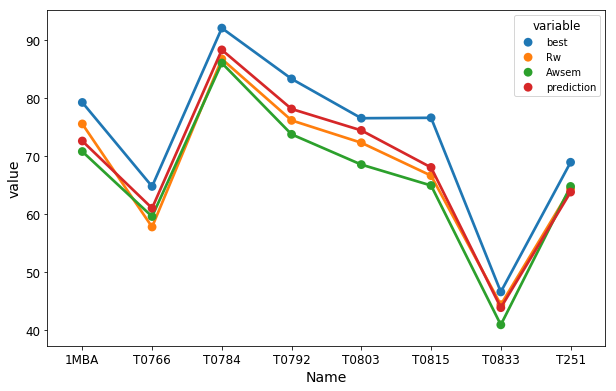

In [138]:
# T0784
label = "GDT"
a2 = best_by_GDT.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

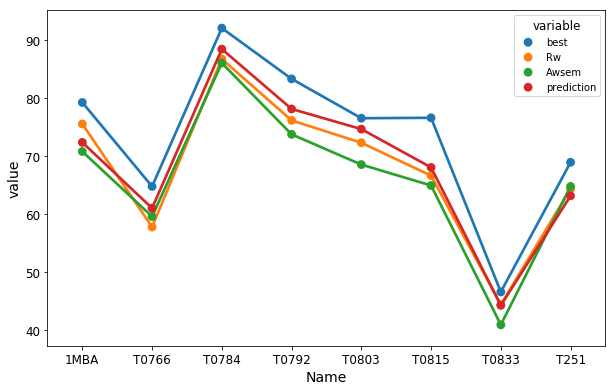

In [122]:
# T0784
label = "GDT"
a2 = best_by_GDT.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

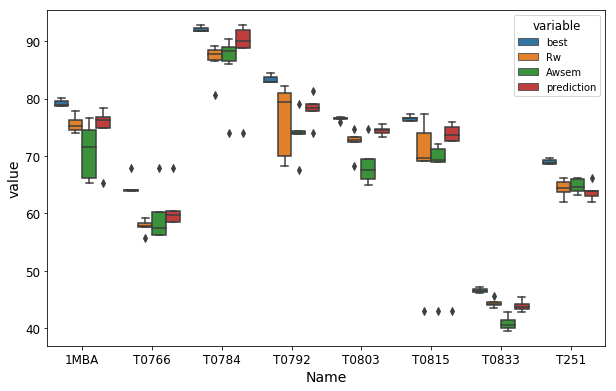

In [114]:
# T0784
label = "GDT"
a2 = best_by_GDT.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.boxplot("Name","value", data=final2, hue="variable")

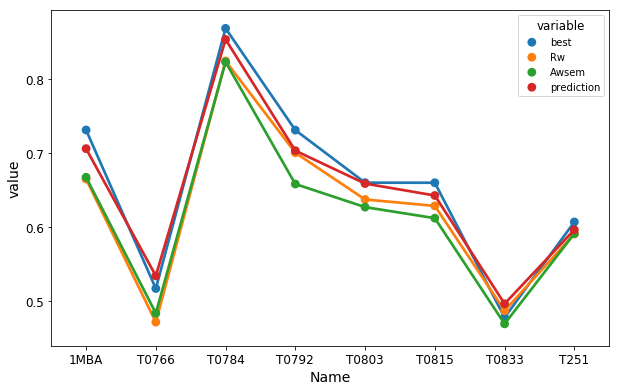

In [99]:
# T0784
label = "Qw"
a2 = best_by_GDT.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

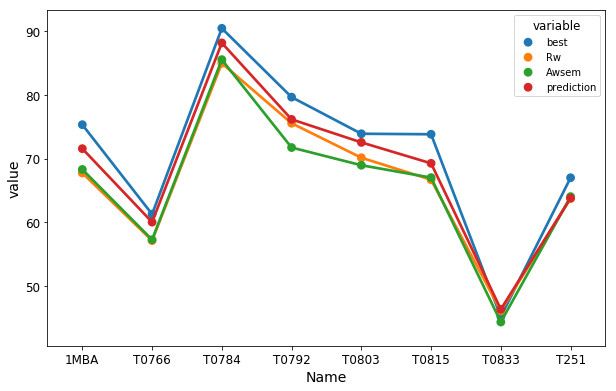

In [97]:
# T0784
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

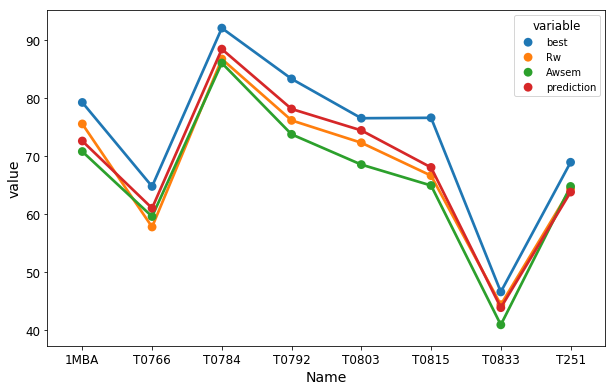

In [12]:
# T0784
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

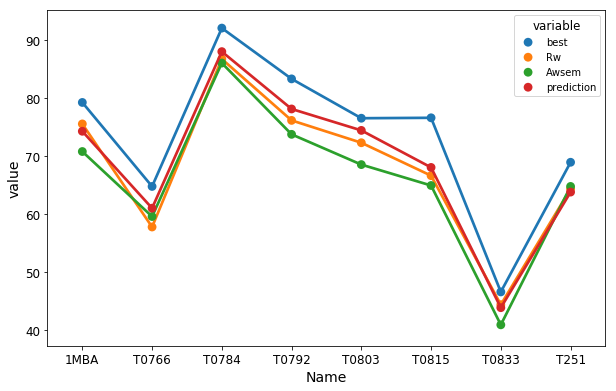

In [15]:
# T0784
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

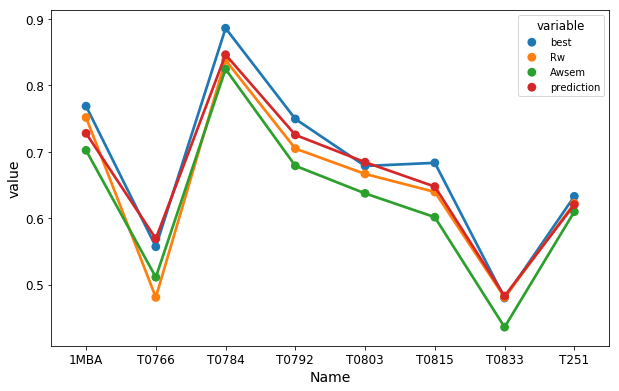

In [17]:
# T0784
label = "Qw"
a2 = best_by_GDT.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [ ]:
# T0784
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [ ]:
# 1mba
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [ ]:
# t0792
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [ ]:
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [ ]:
sns.boxplot("Name","value", data=final2, hue="variable")

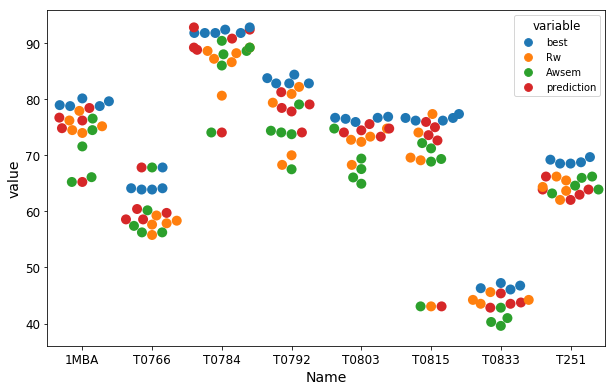

In [60]:
sns.swarmplot(x='Name', y='value', data=final2, hue="variable", size=10)

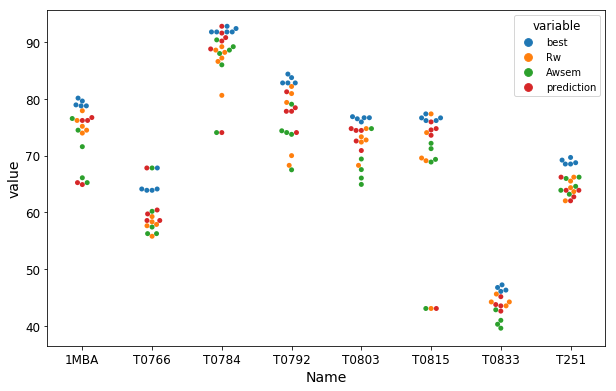

In [51]:
sns.swarmplot(x='Name', y='value', data=final2, hue="variable")

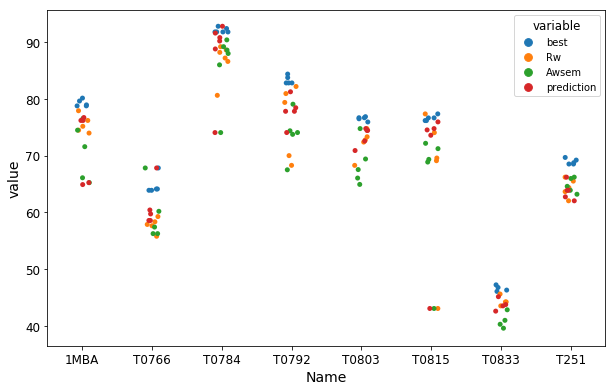

In [52]:
sns.stripplot("Name", "value", data=final2, hue="variable", jitter=True)

In [ ]:
sns.stripplot("value", "Name", data=final2, hue="variable", jitter=True)

In [ ]:
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
sns.pointplot("Name","value", data=final2, hue="variable")
# sns.stripplot("value", "Name", data=final2, hue="variable")

In [ ]:
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
sns.pointplot("Name","value", data=final2, hue="variable")
# sns.stripplot("value", "Name", data=final2, hue="variable")

In [ ]:
np.sum(y_pred != train_y)

In [ ]:
prediction.shape

In [ ]:
raw_test_data.shape

In [ ]:
y_pred.shape

In [ ]:
eval_y.argsort()[-n:][::-1]

In [ ]:
n = 10
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= regr.predict(eval_set)
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1

    position_of_top_n = eval_y.argsort()[-50:][::-1]
    threshold = eval_y[position_of_top_n][-1]
    test_y = np.zeros(len(eval_y),)
    test_y[position_of_top_n] = 1
    plt.figure()
    plt.scatter(test, eval_y)
    plt.show()

#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(test_y, predict_y))

In [ ]:
plt.scatter(y_pred, train_y)

In [ ]:



from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# log_clf = LogisticRegression(random_state=142)
# rnd_clf = RandomForestClassifier(random_state=432)
# svm_clf = SVC(probability=True, random_state=412)
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
log_clf.fit(train_set, train_y)
rnd_clf.fit(train_set, train_y)
svm_clf.fit(train_set, train_y)
voting_clf.fit(train_set, train_y)


# check on training set
n = 10
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
#     y_pred = clf.predict(train_set)
    prob= clf.predict_proba(train_set)[:,1]
    position_of_top_n = prob.argsort()[-n:][::-1]
    threshold = prob[position_of_top_n][-1]
    predict_y = np.zeros(len(train_y),)
    predict_y[position_of_top_n] = 1
#     predict_y = (test > threshold)
#     print(threshold)
    cm = confusion_matrix(train_y, predict_y)
#     print(clf.__class__.__name__, "\n", accuracy_score(train_y, predict_y))
    print(clf.__class__.__name__, "\n", cm)
    
time_stamp = f"{datetime.today().strftime('%d_%h_%H%M%S')}"
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1

    with open(f"/Users/weilu/Research/data/structure_selector/p{p}_poly{PolynomialDegree}_{name}.csv", "w") as f:
        f.write("Result\n")
        for i in test:
            f.write(str(i) + "\n")
#     with open(f"/Users/weilu/Research/data/structure_selector/{name}_results_{time_stamp}.csv", "w") as f:
#         f.write("Result\n")
#         for i in test:
#             f.write(str(i) + "\n")

#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(eval_y, predict_y))
print(f"p{p}_poly{PolynomialDegree}")

In [ ]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_4.csv")
raw_test_data_2 = raw_test_data.drop_duplicates(subset=['Qw', 'Rw', "VTotal"])
raw_test_data_2 = raw_test_data_2.assign(isGood=raw_test_data_2.groupby("Name")["GDT"].rank(ascending=False, method='first') < 50)
raw_test_data = raw_test_data_2
raw_data_T0784 = raw_test_data.groupby("Name").get_group("T0784")
raw_data_T0792 = raw_test_data.groupby("Name").get_group("T0792")
# raw_data = pd.concat([raw_data_T0784, raw_data_T0792])
raw_data = raw_data_T0792

In [ ]:
# FEATURES = ["Rw", "VTotal", "QGO"]
# FEATURES = ["Rw", "VTotal", "QGO", "Burial", "Frag_Mem", "Water"]
# FEATURES = list(raw_test_data.columns[2:-3])
FEATURES = ['Rw',
 'VTotal',
 'QGO',
 'Burial',
 'Water',
 'Rama',
 'DSSP',
 'P_AP',
 'Helix',
 'Frag_Mem']
# LABEL = "Qw"
LABEL = "isGood"
PolynomialDegree = 2
p = 0.1


num_attribs = FEATURES
cat_attribs = [LABEL]
frame = 201
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
my_full_pipeline = Pipeline([
#         ('removeFirstFrame', RemoveFirstFrame(frame)),
        ('featureSelection', full_pipeline)
])
    
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
    strat_train_set = raw_data.iloc[train_index]
    strat_test_set = raw_data.iloc[test_index]
# strat_test_set[LABEL].value_counts() / len(strat_test_set)
X_train = my_full_pipeline.fit_transform(strat_train_set)
X_test = my_full_pipeline.fit_transform(strat_test_set)
train_y = X_train[:,-1]
train_set = X_train[:,:-1]
test_y = X_test[:,-1]
test_set = X_test[:,:-1]



# log_clf = LogisticRegression(random_state=142)
# rnd_clf = RandomForestClassifier(random_state=432)
# svm_clf = SVC(probability=True, random_state=412)
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})

log_clf.fit(train_set, train_y)


# check on training set
n = 5

clf = log_clf
#     y_pred = clf.predict(train_set)
prob= clf.predict_proba(train_set)[:,1]
position_of_top_n = prob.argsort()[-n:][::-1]
threshold = prob[position_of_top_n][-1]
predict_y = np.zeros(len(train_y),)
predict_y[position_of_top_n] = 1
#     predict_y = (test > threshold)
#     print(threshold)
cm = confusion_matrix(train_y, predict_y)
#     print(clf.__class__.__name__, "\n", accuracy_score(train_y, predict_y))
print(clf.__class__.__name__, "\n", cm)



for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1
    print(confusion_matrix(eval_y, predict_y))
print(f"p{p}_poly{PolynomialDegree}")



In [ ]:
strat_train_set["a"] = prob

In [ ]:
strat_train_set.plot("a", "GDT", kind="scatter")

In [ ]:
prob

In [ ]:
pd.concat([strat_train_set, pd.Series(prob)], axis=1)

In [ ]:
def compute_with_my_score_function(p=0.9, PolynomialDegree=3):
    FEATURES = ['Rw',
     'VTotal',
     'QGO',
     'Burial',
     'Water',
     'Rama',
     'DSSP',
     'P_AP',
     'Helix',
     'Frag_Mem']
    # LABEL = "Qw"
    LABEL = "isGood"

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    frame = 201
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    my_full_pipeline = Pipeline([
    #         ('removeFirstFrame', RemoveFirstFrame(frame)),
            ('featureSelection', full_pipeline)
    ])

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
        strat_train_set = raw_data.iloc[train_index]
        strat_test_set = raw_data.iloc[test_index]
    # strat_test_set[LABEL].value_counts() / len(strat_test_set)
    X_train = my_full_pipeline.fit_transform(strat_train_set)
    X_test = my_full_pipeline.fit_transform(strat_test_set)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    test_y = X_test[:,-1]
    test_set = X_test[:,:-1]

    # log_clf = LogisticRegression(random_state=142)
    # rnd_clf = RandomForestClassifier(random_state=432)
    # svm_clf = SVC(probability=True, random_state=412)
    log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
    log_clf.fit(train_set, train_y)

#     voting_clf.fit(train_set, train_y)
    n = 10
    cl_name = "lr"
    clf = log_clf
#     for cl_name, clf in ("voting", voting_clf):
    my_evaluation = 1.0
    another_evaluation = 0.0
    for name, data in raw_test_data.groupby("Name"):
#             print(name)
#         X = full_pipeline.fit_transform(data)
#         validation_data, test_data = train_test_split(X, test_size=0.6, random_state=124)
        validation_data = my_full_pipeline.fit_transform(raw_data_T0784)
        validation_y = validation_data[:,-1]
        validation_set = validation_data[:,:-1]
        clf.fit(train_set, train_y)
        test= clf.predict_proba(validation_set)[:,1]
        position_of_top_n = test.argsort()[-n:][::-1]
        threshold = test[position_of_top_n][-1]
        predict_y = np.zeros(len(validation_y),)
        predict_y[position_of_top_n] = 1
    #     predict_y = (test > threshold)
#         print(threshold)
        cm = confusion_matrix(validation_y, predict_y)
#             print(cm)
        precision = cm[1][1] / (cm[1][1] + cm[0][1])
#             print(name,  " precision", precision,end = " ")
        if name != "T0766" and name != "T0833":
            my_evaluation *= precision
            another_evaluation += precision
#         print("")
    print("classifier:", cl_name, ", p:",p, ", degree", PolynomialDegree, ", score", my_evaluation, ", another score", another_evaluation)
    return (cl_name, p, PolynomialDegree, my_evaluation)

In [ ]:
def myGridSerach():
    p_list = [0.9, 0.8, 0.7, 0.5, 0.1]
    degree_list = [3, 2, 1]
#     p_list = [0.1, 0.8, 0.9, 0.95]
#     degree_list = [1, 2, 3]
#     p_list = [0.1, 0.15, 0.2, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95]
#     degree_list = [1, 2, 3, 4]
    result = []
    for p in p_list:
        for degree in degree_list:
            result += [compute_with_my_score_function(p, degree)]
            

In [ ]:
myGridSerach()

In [ ]:
compute_with_my_score_function(0.1, 1)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")

In [ ]:
num_attribs = FEATURES
cat_attribs = [LABEL]
frame = 201
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
my_full_pipeline = Pipeline([
#         ('removeFirstFrame', RemoveFirstFrame(frame)),
        ('featureSelection', full_pipeline)
])

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
    strat_train_set = raw_data.iloc[train_index]
    strat_test_set = raw_data.iloc[test_index]
# strat_test_set[LABEL].value_counts() / len(strat_test_set)
X_train = my_full_pipeline.fit_transform(strat_train_set)
X_test = my_full_pipeline.fit_transform(strat_test_set)
train_y = X_train[:,-1]
train_set = X_train[:,:-1]
test_y = X_test[:,-1]
test_set = X_test[:,:-1]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# log_clf = LogisticRegression(random_state=142)
# rnd_clf = RandomForestClassifier(random_state=432)
# svm_clf = SVC(probability=True, random_state=412)
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
log_clf.fit(train_set, train_y)
rnd_clf.fit(train_set, train_y)
svm_clf.fit(train_set, train_y)
voting_clf.fit(train_set, train_y)

In [ ]:
# check on training set
n = 10
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
#     y_pred = clf.predict(train_set)
    prob= clf.predict_proba(train_set)[:,1]
    position_of_top_n = prob.argsort()[-n:][::-1]
    threshold = prob[position_of_top_n][-1]
    predict_y = np.zeros(len(train_y),)
    predict_y[position_of_top_n] = 1
#     predict_y = (test > threshold)
#     print(threshold)
    cm = confusion_matrix(train_y, predict_y)
#     print(clf.__class__.__name__, "\n", accuracy_score(train_y, predict_y))
    print(clf.__class__.__name__, "\n", cm)

In [ ]:
time_stamp = f"{datetime.today().strftime('%d_%h_%H%M%S')}"
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1

    with open(f"/Users/weilu/Research/data/structure_selector/p{p}_poly{PolynomialDegree}_{name}.csv", "w") as f:
        f.write("Result\n")
        for i in test:
            f.write(str(i) + "\n")
#     with open(f"/Users/weilu/Research/data/structure_selector/{name}_results_{time_stamp}.csv", "w") as f:
#         f.write("Result\n")
#         for i in test:
#             f.write(str(i) + "\n")

#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(eval_y, predict_y))

In [ ]:
time_stamp = f"{datetime.today().strftime('%d_%h_%H%M%S')}"
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = my_full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1


#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(eval_y, predict_y))